In [1]:
import yfinance as yf 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import random
from IPython.display import clear_output
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get data

In [2]:
start_date = '2020-01-01'
end_date = datetime.datetime.now()

ticker_list = ['AAPL', 'AMZN','PEP', 'SONY']
all_data = yf.download(ticker_list, start_date, end_date)
all_prices = all_data['Adj Close']
all_prices = all_prices.reset_index(inplace=False)
all_prices = all_prices.set_index('Date')
#print(all_prices.tail(3))

[*********************100%***********************]  4 of 4 completed


# Decide on Amount of Days Per Rebalance

In [3]:
split_size = 15

## Split data into chunks to rebalance port every x days

In [4]:
def splitDataFrameIntoSmaller(df, chunksize):
    list_of_df = list()
    no_chunks = (len(df) // chunksize)+1
    for i in range(no_chunks):
        list_of_df.append(df[i*chunksize:(i+1)*chunksize])
    return list_of_df


date_chunks = splitDataFrameIntoSmaller(all_prices, split_size)
No_Updates = len(date_chunks)
print(len(date_chunks))

24


In [5]:
# Function to get portfolio with minimum weightings in each stock
def get_diversified_port():
    column_names = portfolios.columns
    stock_columns = list(column_names[2:-1])
    min_weight = 1/(len(stock_columns) * 2)
    # Make sure each stock has minimum weight in portofolio comp
    chosen_weightings = portfolios[(portfolios[stock_columns] > min_weight)][stock_columns].dropna()
    trimmed = portfolios.loc[chosen_weightings.index]
    # Best 5 portfolios with min weight
    best_weights = trimmed.nlargest(5, 'Sharpe')
    best_weights['P Weight Var'] = best_weights.iloc[:,2:-1].var(axis=1)
    # Choose most balanced of top 5
    diversified = (best_weights[best_weights['P Weight Var']==best_weights['P Weight Var'].min()])
    diversified = diversified.iloc[:,:-1]
    return diversified

## Use loop to find optimal sharpe ratio portfolio at each interval and store portfolio weightings

In [6]:
optimal_weights = pd.DataFrame()
type(optimal_weights)
for i in range(0,(No_Updates)):
    clear_output(wait=True)
    # Establish used prices as current iteration of df list
    prices = date_chunks[i]
    # Calc returns
    returns = prices.pct_change()
    # Create cov and corr matrices
    cov_matrix = returns.apply(lambda x: np.log(1+x)).cov()
    corr_matrix = returns.apply(lambda x: np.log(1+x)).corr()
    # Establish expected returns
    er = (returns.mean())
    # Annualizing average daily returns
    for x in range(0,4):
        er[x]=((er[x]+1)**250)-1
        
    # Prepare loop of portfolio creation
    p_ret=[]
    p_vol=[]
    p_weights = []

    num_assets = len(returns.columns)
    num_portfolios = int(800*1.5**(num_assets))
    for portfolio in range(num_portfolios):
        clear_output(wait=True)
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        rets = np.dot(weights, er)
        p_ret.append(rets)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var)
        ann_sd = sd*np.sqrt(len(returns.index))
        p_vol.append(ann_sd)
        print('Current portfolio progress:', np.round(portfolio/num_portfolios *100, 2), '%')
        print('Total progress:', np.round(i/No_Updates *100, 2), '%')
        
    data1 = {'Returns': p_ret, 'Volatility': p_vol}
    for counter, symbol in enumerate(returns.columns.tolist()):
        data1[symbol+ ' Weight'] = [w[counter] for w in p_weights]
    portfolios = pd.DataFrame(data1)
    rf_data = yf.download('^TNX', prices.index[0], prices.index[-1])
    rf_returns = rf_data['Adj Close']
    rfr = (rf_returns.mean())/100 # divide by 100 to convert to x percent
    portfolios['Sharpe']=(portfolios['Returns']-rfr)/portfolios['Volatility']
    # Choose portfolios to use
    chosen = get_diversified_port()
    optimal_weights = pd.concat([optimal_weights, chosen])
    
    
opt_weights = optimal_weights.iloc[:,2:-1]
opt_weights = opt_weights.values

Current portfolio progress: 99.98 %
Total progress: 95.83 %
[*********************100%***********************]  1 of 1 completed


In [7]:
optimal_weights

,Returns,Volatility,AAPL Weight,AMZN Weight,PEP Weight,SONY Weight,Sharpe
917,1.483153,0.021658,0.191126,0.126503,0.409418,0.272952,67.642518
846,5.086508,0.032950,0.128344,0.382807,0.338760,0.150089,153.887133
2749,-0.804781,0.119936,0.503271,0.130580,0.149476,0.216673,-6.815002
2038,1.217407,0.207262,0.130184,0.486188,0.126635,0.256993,5.832231
1757,19.244529,0.091537,0.184283,0.491851,0.186378,0.137487,210.162747
1631,9.139510,0.052132,0.475473,0.127886,0.215227,0.181414,175.193635
568,0.918408,0.030443,0.302039,0.412168,0.149569,0.136224,29.946444
1620,5.492355,0.064962,0.360359,0.365128,0.141972,0.132541,84.431073
3274,3.308053,0.044635,0.344790,0.133837,0.153640,0.367732,73.967170
3313,4.299648,0.053081,0.327352,0.132355,0.387866,0.152427,80.892791


# Establish positions and portfolio df's

In [8]:
positions = pd.DataFrame()
portfolio = pd.DataFrame()
initial_capital = [100000.0]
# Subtract one from range and add one to date_chunks indexing to use weights
# against future prices
for i in range(0,(No_Updates-1)):
    # Establish used prices as current iteration of df list
    prices = date_chunks[i+1]
    pos = pd.DataFrame(index=prices.index).fillna(0.0)
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        pos[symbol+ ' Shares'] = ((opt_weights[i][counter]*initial_capital[i])/prices.iloc[0,counter])
       
    positions = pd.concat([positions, pos])
    col_list= []
    for counter, symbol in enumerate(all_prices.columns.tolist()):
        col_list.append(symbol+ ' Value')
    # Initialize portfolio
    port = pd.DataFrame(prices.values*pos.values, columns=col_list, index=pos.index)
    port['total'] = port.sum(axis=1)
    initial_capital.append(port['total'][-1])
    portfolio = pd.concat([portfolio, port])
portfolio['returns'] = portfolio['total'].pct_change()
portfolio

,AAPL Value,AMZN Value,PEP Value,SONY Value,total,returns
Date,,,,,,
2020-01-24,19112.622915,12650.344391,40941.795382,27295.237311,100000.000000,NaN
2020-01-27,18550.610301,12424.061607,40718.347490,27078.789377,98771.808775,-0.012282
2020-01-28,19075.395703,12593.331986,40804.288638,27348.399758,99821.416085,0.010627
2020-01-29,19474.686202,12625.609513,40600.892017,27264.860839,99966.048572,0.001449
2020-01-30,19446.466351,12711.773887,41202.475522,27014.235390,100374.951150,0.004090
...,...,...,...,...,...,...
2021-05-25,29294.512236,23437.864745,84041.954573,28421.384831,165195.716386,0.004644
2021-05-26,29282.969171,23481.804589,84041.954573,28441.613487,165248.341820,0.000319
2021-05-27,28920.539110,23229.739549,83027.552592,28773.943293,163951.774544,-0.007846


In [9]:
PortfolioSections = portfolio.reset_index(inplace=False)
PortfolioSections = PortfolioSections[PortfolioSections.index % split_size == 0]  # Selects every n'th row excluding 0
PortfolioSections = PortfolioSections.set_index('Date')
PortfolioSections['returns'] = PortfolioSections['total'].pct_change()
port_cols = list(PortfolioSections.columns)
format_dict = {port_cols[0]:'${0:,.0f}' , port_cols[1]:'${0:,.0f}' , port_cols[2]:'${0:,.0f}' , port_cols[3]:'${0:,.0f}' ,'total':'${0:,.0f}','returns': '{:.2%}'}
print('Portfolio Value at End Of Ea Rebalance:')
PortfolioSections.style.format(format_dict)

Portfolio Value at End Of Ea Rebalance:


,AAPL Value,AMZN Value,PEP Value,SONY Value,total,returns
Date,,,,,,
2020-01-24 00:00:00,"$19,113","$12,650","$40,942","$27,295","$100,000",nan%
2020-02-14 00:00:00,"$13,162","$39,257","$34,740","$15,392","$102,550",2.55%
2020-03-09 00:00:00,"$47,025","$12,201","$13,967","$20,246","$93,439",-8.88%
2020-03-30 00:00:00,"$11,728","$43,800","$11,408","$23,152","$90,089",-3.58%
2020-04-21 00:00:00,"$18,947","$50,570","$19,162","$14,136","$102,815",14.13%
2020-05-12 00:00:00,"$51,979","$13,981","$23,529","$19,832","$109,321",6.33%
2020-06-03 00:00:00,"$33,917","$46,284","$16,796","$15,297","$112,293",2.72%
2020-06-24 00:00:00,"$44,328","$44,914","$17,464","$16,304","$123,010",9.54%
2020-07-16 00:00:00,"$45,960","$17,840","$20,480","$49,018","$133,297",8.36%


## Plot frequency of returns for rebalances

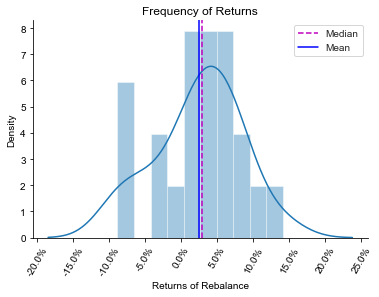

In [10]:
fig, ax0 = plt.subplots()
sns.set_style('white')
sns.set_palette('bright')
sns.despine()

rebalance_returns = PortfolioSections['returns']

sns.distplot(rebalance_returns, kde=True, bins=10, ax=ax0)
ax0.set(xlabel = 'Returns of Rebalance', title='Frequency of Returns')

ax0.axvline(x=rebalance_returns.median(), color='m', label='Median', linestyle='--')
ax0.axvline(x=rebalance_returns.mean(), color='b', label='Mean', linestyle='-')

ax0.xaxis.label.set_color('black')
ax0.yaxis.label.set_color('black')
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis='y', colors='black')

ax0.xaxis.set_major_locator(plt.MaxNLocator(10))
vals = ax0.get_xticks()
ax0.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xticks(rotation=60)

ax0.legend()
plt.show()

## Show average portfolio balance

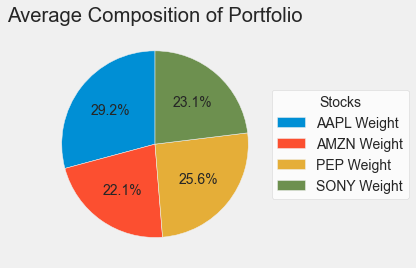

In [11]:
rebalance_weights = optimal_weights.iloc[:-1,2:-1]

#print(rebalance_weights.shape)
#print(PortfolioSections.shape)
avg_portfolio_composition = rebalance_weights.mean()
plt.style.use('fivethirtyeight')
fig1, ax1 = plt.subplots()
ax1.set(title='Average Composition of Portfolio')
ax1.pie(avg_portfolio_composition, autopct='%1.1f%%', startangle=90)
plt.legend(title='Stocks', bbox_to_anchor=(1.0,0.5), loc="center left", borderaxespad=0, facecolor='white', labels=avg_portfolio_composition.index)
plt.show()

# Get index data for comparison

In [12]:
index_data = yf.download('^GSPC', date_chunks[1].index[0], end_date)
index_data['returns'] = index_data['Adj Close'].pct_change()

portfolio['Std Value'] = portfolio['total'] / portfolio['total'].iloc[0] * 100
index_data['Std Value'] = index_data['Adj Close'] / index_data['Adj Close'].iloc[0] * 100

[*********************100%***********************]  1 of 1 completed


# Plot Results


Current portfolio value is: $164,330.79
Portfolio annualized return is: 43.93%
Index annualized return is: 19.64%


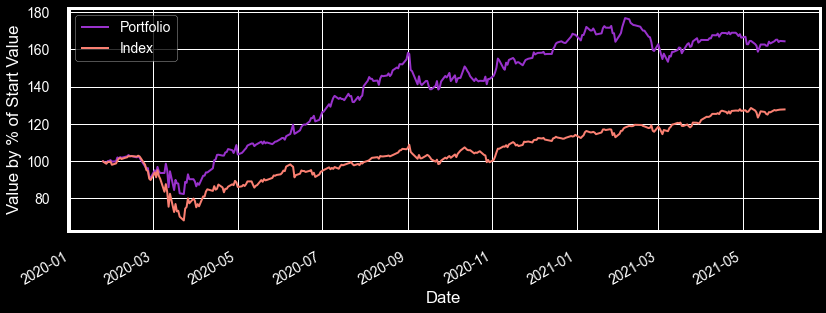

In [18]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(12,10))
fig.patch.set_facecolor('black')
ax1 = fig.add_subplot(211, ylabel='Value by % of Start Value')
portfolio['Std Value'].plot(ax=ax1, color='darkorchid', lw=2.)
index_data['Std Value'].plot(ax=ax1, color='salmon', lw=2.)
legend_labels = ['Portfolio', 'Index']
plt.legend(labels=legend_labels)

# Add ticks for portfolio rebalance
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, split_size), minor=True)
ax1.tick_params(which='major', length= 15, width=2)
ax1.tick_params(which='minor', length= 5, color='grey')

# Get final value of portfolio
portfolio_value = (portfolio.iloc[-1,-3])
# Calc cumulative returns of port and index
cum_port_change = (1+portfolio['returns']).cumprod()
cum_index_change = (1+index_data['returns']).cumprod()
# Annualize
portfolio_cum_ret = (cum_port_change**(250/len(portfolio.index)))-1
index_cum_ret = (cum_index_change**(250/len(index_data.index)))-1
# Slice most recent date
portfolio_ret= portfolio_cum_ret[-1]
index_ret = index_cum_ret[-1]

print('\nCurrent portfolio value is: $'+ str('{:,.2f}'.format(portfolio_value)))
print('Portfolio annualized return is: '+ str("{:.2%}".format(portfolio_ret)))
print('Index annualized return is: '+ str("{:.2%}".format(index_ret)))
plt.show()